# Win Probability Model: Classifier Comparison

This notebook compares several classifiers for predicting match win probability from per-player snapshot stats at different minute marks (10, 15, 20, 25). We evaluate overall metrics and how accuracy and ROC AUC vary with time.

Models tested:
- Logistic Regression (baseline)
- Random Forest
- Gradient Boosting (sklearn)
- Extra Trees
- HistGradientBoosting
- Calibrated (Isotonic) Logistic Regression

Metrics: accuracy, ROC AUC, Brier score, log loss. We also compute per-minute metrics for the top model.

In [2]:
# Imports & setup
import pandas as pd
import numpy as np
from pathlib import Path

from prometheus.win_prediction import (
    build_win_prediction_training_set,
    _prepare_feature_matrix,
    build_logistic_pipeline,
    evaluate_binary_classifier,
    evaluate_per_minute_metrics,
)
from prometheus import DB_PATH

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RANDOM_STATE = 42
MINUTES = (10,15,20,25)
YEARS = None  # use all

df = build_win_prediction_training_set(years=YEARS, minutes=MINUTES, db_path=DB_PATH)
print(f"Base dataset shape: {df.shape}")
X, y, num_feats, cat_feats = _prepare_feature_matrix(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train rows: {len(X_train)} | Test rows: {len(X_test)}")

Base dataset shape: (2377668, 18)
Train rows: 1902134 | Test rows: 475534
Train rows: 1902134 | Test rows: 475534


In [3]:
# Define candidate classifiers
candidates = {
    'logistic': LogisticRegression(max_iter=300, class_weight='balanced', solver='lbfgs'),
    # 'random_forest': RandomForestClassifier(n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'),
    # 'extra_trees': ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'),
    # 'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    # 'hist_gb': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    'xgboost': XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        objective='binary:logistic',
        eval_metric='logloss',
        n_jobs=-1,
        tree_method='hist',
    ),
}

# Calibrated logistic (isotonic) on a smaller base to avoid overfit risk
base_log_reg = LogisticRegression(max_iter=300, class_weight='balanced', solver='lbfgs')
calibrated = CalibratedClassifierCV(base_log_reg, method='isotonic', cv=3)
candidates['calibrated_logistic'] = calibrated

results = []
models = {}
for name, clf in candidates.items():
    pipe = build_logistic_pipeline(num_feats, cat_feats, classifier=clf)
    pipe.fit(X_train, y_train)
    train_metrics = evaluate_binary_classifier(pipe, X_train, y_train)
    test_metrics = evaluate_binary_classifier(pipe, X_test, y_test)
    results.append({
        'model': name,
        'train_accuracy': train_metrics['accuracy'],
        'test_accuracy': test_metrics['accuracy'],
        'test_roc_auc': test_metrics['roc_auc'],
        'test_brier': test_metrics['brier'],
        'test_log_loss': test_metrics['log_loss'],
    })
    models[name] = pipe
    
    print(f"Model: {name} | acc {test_metrics['accuracy']:.4f} | roc_auc {test_metrics['roc_auc']:.4f} | brier {test_metrics['brier']:.4f} | log_loss {test_metrics['log_loss']:.4f}")

results_df = pd.DataFrame(results).sort_values('test_roc_auc', ascending=False).reset_index(drop=True)
results_df

Model: logistic | acc 0.6823 | roc_auc 0.7572 | brier 0.1991 | log_loss 0.5783
Model: xgboost | acc 0.6847 | roc_auc 0.7620 | brier 0.1972 | log_loss 0.5735
Model: xgboost | acc 0.6847 | roc_auc 0.7620 | brier 0.1972 | log_loss 0.5735
Model: calibrated_logistic | acc 0.6822 | roc_auc 0.7572 | brier 0.1991 | log_loss 0.5783
Model: calibrated_logistic | acc 0.6822 | roc_auc 0.7572 | brier 0.1991 | log_loss 0.5783


,model,train_accuracy,test_accuracy,test_roc_auc,test_brier,test_log_loss
0,xgboost,0.687305,0.684721,0.762033,0.197176,0.573479
1,logistic,0.683348,0.682254,0.757231,0.199075,0.578296
2,calibrated_logistic,0.683371,0.682204,0.757224,0.199065,0.578275


In [4]:
# Select best model by ROC AUC and compute per-minute metrics
best_name = results_df.iloc[0]['model']
best_model = models[best_name]
print(f"Best model: {best_name}")
per_minute = evaluate_per_minute_metrics(best_model, X_test, y_test)
per_minute

Best model: xgboost


,minutes,n_rows,accuracy,roc_auc,brier,log_loss
0,10,118985,0.601370,0.645456,0.233410,0.658729
1,15,118670,0.647940,0.706626,0.217386,0.623713
2,20,118983,0.705370,0.780153,0.190985,0.562306
3,25,118896,0.784181,0.869917,0.146940,0.449209


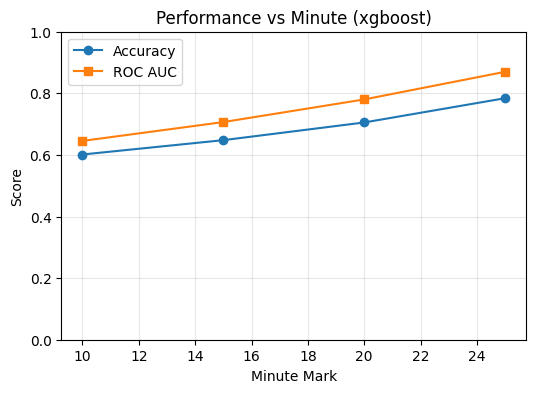

,minutes,n_rows,accuracy,roc_auc,brier,log_loss
0,10,118985,0.601370,0.645456,0.233410,0.658729
1,15,118670,0.647940,0.706626,0.217386,0.623713
2,20,118983,0.705370,0.780153,0.190985,0.562306
3,25,118896,0.784181,0.869917,0.146940,0.449209


In [5]:
# Plot accuracy & ROC AUC vs minutes
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(per_minute['minutes'], per_minute['accuracy'], marker='o', label='Accuracy')
plt.plot(per_minute['minutes'], per_minute['roc_auc'], marker='s', label='ROC AUC')
plt.title(f'Performance vs Minute ({best_name})')
plt.xlabel('Minute Mark')
plt.ylabel('Score')
plt.ylim(0,1)
plt.grid(alpha=0.3)
plt.legend()
plt.show()
per_minute

In [7]:
# XGBoost hyperparameter tuning function (moved from module into notebook)

def tune_xgboost_win_probability(
    years=None,
    minutes=(10,15,20,25),
    db_path=DB_PATH,
    test_size: float = 0.2,
    random_state: int = 42,
    param_grid: list[dict] | None = None,
    max_models: int | None = None,
):
    """Brute-force evaluate XGBoost hyperparameters.

    Returns dict with: results_df (sorted), best_params, best_metrics, best_model.

    Notes:
      * Single train/test split (fast). For rigor, wrap in CV.
      * Uses existing preprocessing pipeline so categorical + scaling is consistent.
    """
    df_local = build_win_prediction_training_set(years=years, minutes=minutes, db_path=db_path)
    X, y, num_feats, cat_feats = _prepare_feature_matrix(df_local)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    if param_grid is None:
        # Compact default grid (48 combos)
        param_grid = []
        for lr in [0.03, 0.05, 0.1]:
            for md in [4, 5]:
                for ne in [300, 500]:
                    for ss in [0.8, 1.0]:
                        for cs in [0.8, 1.0]:
                            param_grid.append({
                                'learning_rate': lr,
                                'max_depth': md,
                                'n_estimators': ne,
                                'subsample': ss,
                                'colsample_bytree': cs,
                                'reg_lambda': 1.0,
                                'min_child_weight': 1,
                            })

    if max_models is not None:
        param_grid = param_grid[:max_models]

    results = []
    best_auc = -1.0
    best_model = None
    best_params = None
    best_metrics = None

    for idx, params in enumerate(param_grid, start=1):
        clf = XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            tree_method='hist',
            random_state=random_state,
            n_jobs=-1,
            **params,
        )
        pipe = build_logistic_pipeline(num_feats, cat_feats, classifier=clf)
        pipe.fit(X_train, y_train)
        test_metrics = evaluate_binary_classifier(pipe, X_test, y_test)
        row = {"index": idx, **params, **{f"test_{k}": v for k, v in test_metrics.items()}}
        results.append(row)
        if test_metrics['roc_auc'] > best_auc:
            best_auc = test_metrics['roc_auc']
            best_model = pipe
            best_params = params
            best_metrics = test_metrics

    results_df = pd.DataFrame(results).sort_values('test_roc_auc', ascending=False).reset_index(drop=True)
    return {
        'results_df': results_df,
        'best_params': best_params,
        'best_metrics': best_metrics,
        'best_model': best_model,
        'searched': len(results_df),
    }

In [8]:
# Run XGBoost tuning (limited models for speed)
small_grid = [
    {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda':1.0, 'min_child_weight':1},
    {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0, 'colsample_bytree': 0.8, 'reg_lambda':1.0, 'min_child_weight':1},
    {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_lambda':2.0, 'min_child_weight':1},
]

xgb_tuning = tune_xgboost_win_probability(param_grid=small_grid, max_models=None)
print('Tested models:', xgb_tuning['searched'])
print('Best params:', xgb_tuning['best_params'])
print('Best metrics:', xgb_tuning['best_metrics'])
xgb_tuning['results_df']

Tested models: 3
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_lambda': 1.0, 'min_child_weight': 1}
Best metrics: {'roc_auc': 0.762032767161083, 'brier': 0.19717618335791162, 'log_loss': 0.573479412921502, 'accuracy': 0.6847207560342689}


,index,learning_rate,max_depth,n_estimators,subsample,colsample_bytree,reg_lambda,min_child_weight,test_roc_auc,test_brier,test_log_loss,test_accuracy
0,1,0.05,5,400,0.9,0.9,1.0,1,0.762033,0.197176,0.573479,0.684721
1,3,0.03,5,500,0.9,1.0,2.0,1,0.761549,0.197361,0.573944,0.684586
2,2,0.05,4,500,1.0,0.8,1.0,1,0.761508,0.197379,0.573986,0.684792


### Next Steps
- Add grouped train/test split by `gameid` to remove potential leakage.
- Try LightGBM / XGBoost for potentially higher ROC AUC.
- Calibrate best tree-based model (isotonic) and compare Brier score.
- Aggregate player-minute rows to team-minute aggregates and re-run experiments.
